In [1]:
using PyPlot
using QuantumOptics

using DataFrames
using CSV

In [15]:
include("../src/ColdAtoms.jl");
using .ColdAtoms

In [3]:
include("../params/Browayes_Dopler.jl");

### Atom in dipole trap, choice of constants.

__Potential energy__

$\Pi = U_0 \left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$


__Kinetic energy__

$K = \frac{m V^2}{2}$


__Total energy__

$E = \Pi + K$



__Constants__

$E = \varepsilon E_0, \;\;\; E_0 = 1\mu K$


$kT = t E_0$ 


$V = v v_0, \;\;\; v_0 = \sqrt{\frac{E_0}{m}}$


$R = r r_0, \;\;\; r_0 = 1\mu m$


__Dimensionless units__


$\Pi =  u_0 E_0 \left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$


$K = E_0\frac{v^2}{2}$


$p(x,y,z,v_x,v_y,v_z) \sim exp\left(- \frac{u_0}{t}\left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right) \right)exp\left(- \frac{v_x^2+v_y^2+v_z^2}{2t} \right)$


Markov Chain Monte Carlo is used to generate initial conditions $(x,y,z,v_x,v_y,v_z)|_{t=0}$

__Harmonic approximation__


For $T\ll U_0$ gaussian potential can be replaced with harmonic one.

$U(x,y,z)=U_0\left( \frac{2(x^2+y^2)}{w_0^2} + \frac{z^2}{z_0^2}\right) = 
\frac{m \omega_r ^2 (x^2+y^2)}{2} + \frac{m \omega_z ^2 (z^2)}{2}$, where 

$\omega_r = \sqrt{\frac{4 U_0}{m w_0^2}} = \frac{2}{w_0} \sqrt{\frac{U_0}{E_0}}\sqrt{\frac{E_0}{m}} = 2 \frac{v_0}{w_0}  \sqrt{u_0}$

$\omega_z = \sqrt{\frac{2 U_0}{m z_0^2}} = \sqrt{2}\frac{v_0}{z_0}  \sqrt{u_0}$.


_In that case atom dynamics is integrable:_

$H = \frac{m \omega_r ^2 (x^2+y^2)}{2} + \frac{m \omega_z ^2 (z^2)}{2} + \frac{m(v_x^2+v_y^2+v_z^2)}{2}$

$x(t)=x_0 \cos(\omega_r t) + \frac{v_{x0}}{\omega_r}\sin(\omega_r t)$,

$y(t)=y_0 \cos(\omega_r t) + \frac{v_{y0}}{\omega_r}\sin(\omega_r t)$,

$z(t)=z_0 \cos(\omega_r t) + \frac{v_{z0}}{\omega_z}\sin(\omega_r t)$

$(x_0,y_0,z_0,v_{x0},v_{y0},v_{z0})$ can be sampled using Monte-Carlo

### Atom motion in dipole tweezer as a source of decoherence.

Atom motion in optical tweezer leads to several effects, which cause decoherence of Rydberg two-photon excitation:

- Doppler shifts

- Position-dependent Rabi frequencies

- Position-dependent AC Stark shifts

### Doppler effect in two-level system(TLS). 

Sylvain de Léséleuc, Daniel Barredo, Vincent Lienhard, Antoine Browaeys, and Thierry Lahaye, "Analysis of imperfections in the coherent optical excitation of single atoms to Rydberg states"

![Doppler effect](./images/Browayes_Doppler.png)

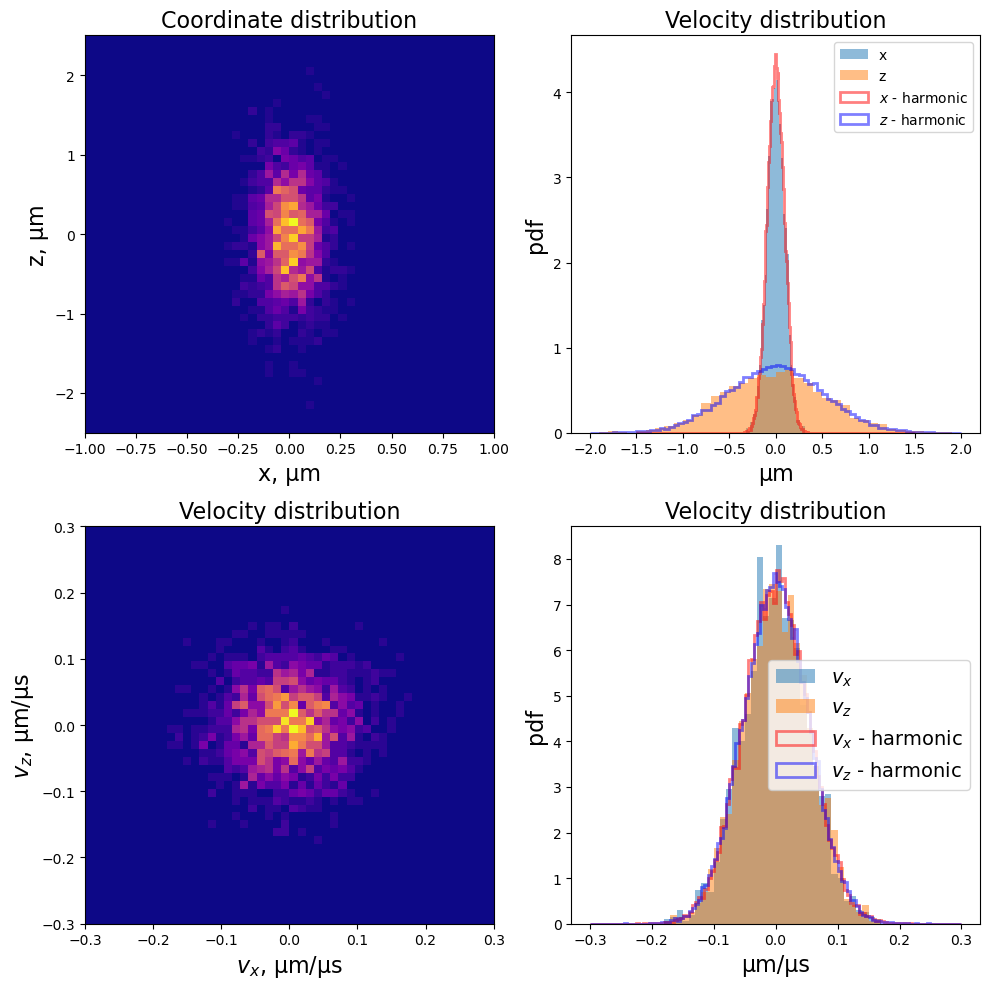

In [16]:
N = 2000;
samples, acc_rate = samples_generate(trap_params, atom_params, N; freq=200, skip=2000, harmonic=false);
samples_h, acc_rate_h = samples_generate(trap_params, atom_params, N*20; freq=200, skip=2000, harmonic=true);
ColdAtoms.samples_visualise_eng(samples; samples_harmonic=samples_h, harmonic=true)
gcf()
# savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/mcmc.svg")
# savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/mcmc.pdf")
# savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/mcmc.png")

# savefig("/Users/goloshch/Desktop/Materials/Workshops:Conferences/2023/ФУХА/presentation/images/mcmc_eng.png")

In [ ]:
ColdAtoms.samples_visualise_rus(samples)
gcf()

In [5]:

N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);

Δ0 = 2.0*π * 904.0;
Ω =  2.0*π * 0.25;
Ωr = sqrt(2.0*Δ0 * Ω);
Ωb = sqrt(2.0*Δ0 * Ω);

red_laser_params = [Ωr, wr, zr];
blue_laser_params = [Ωb, wb, zb];
detuning_params = [Δ0, δ_twophoton(Ωr, Ωb, Δ0)];

T0_250 = T_twophoton(Ωr, Ωb, Δ0);
tspan_250 = [0.0:T0_250/40:3.1*T0_250;];
ψ0 = g;

ρ_mean_250, ρ2_mean_250 = 
    simulation(
        tspan_250, ψ0, 
        
        atom_params,
        trap_params,
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        free_motion=true,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=true
    );

In [6]:
N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);

Δ0 = 2.0*π * 904.0;
Ω =  2.0*π * 0.5;
Ωr = sqrt(2.0*Δ0 * Ω);
Ωb = sqrt(2.0*Δ0 * Ω);

red_laser_params = [Ωr, wr, zr];
blue_laser_params = [Ωb, wb, zb];
detuning_params = [Δ0, δ_twophoton(Ωr, Ωb, Δ0)];

T0_500 = T_twophoton(Ωr, Ωb, Δ0);
tspan_500 = [0.0:T0_500/40:3.1*T0_500;];
ψ0 = g;

ρ_mean_500, ρ2_mean_500 = 
    simulation(
        tspan_500, ψ0, 
        
        atom_params,
        trap_params,
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        free_motion=true,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=true
    );


In [7]:
N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);

Δ0 = 2.0*π * 904.0;
Ω =  2.0*π * 1.0;
Ωr = sqrt(2.0*Δ0 * Ω);
Ωb = sqrt(2.0*Δ0 * Ω);

red_laser_params = [Ωr, wr, zr];
blue_laser_params = [Ωb, wb, zb];
detuning_params = [Δ0, δ_twophoton(Ωr, Ωb, Δ0)];

T0_1000 = T_twophoton(Ωr, Ωb, Δ0);
tspan_1000 = [0.0:T0_1000/40:3.1*T0_1000;];
ψ0 = g;

ρ_mean_1000, ρ2_mean_1000 = 
    simulation(
        tspan_1000, ψ0, 
        
        atom_params,
        trap_params,
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        free_motion=true,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=true
    );


In [8]:
N = 100;
samples, acc_rate = samples_generate(trap_params, atom_params, N; skip=5000, freq=1000);

Δ0 = 2.0*π * 904.0;
Ω =  2.0*π * 2.0;
Ωr = sqrt(2.0*Δ0 * Ω);
Ωb = sqrt(2.0*Δ0 * Ω);

red_laser_params = [Ωr, wr, zr];
blue_laser_params = [Ωb, wb, zb];
detuning_params = [Δ0, δ_twophoton(Ωr, Ωb, Δ0)];

T0_2000 = T_twophoton(Ωr, Ωb, Δ0);
tspan_2000 = [0.0:T0_2000/40:3.1*T0_2000;];
ψ0 = g;

ρ_mean_2000, ρ2_mean_2000 = 
    simulation(
        tspan_2000, ψ0, 
        
        atom_params,
        trap_params,
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        atom_motion=true,
        free_motion=true,
        laser_noise=false,
        spontaneous_decay=false,
        parallel=true
    );

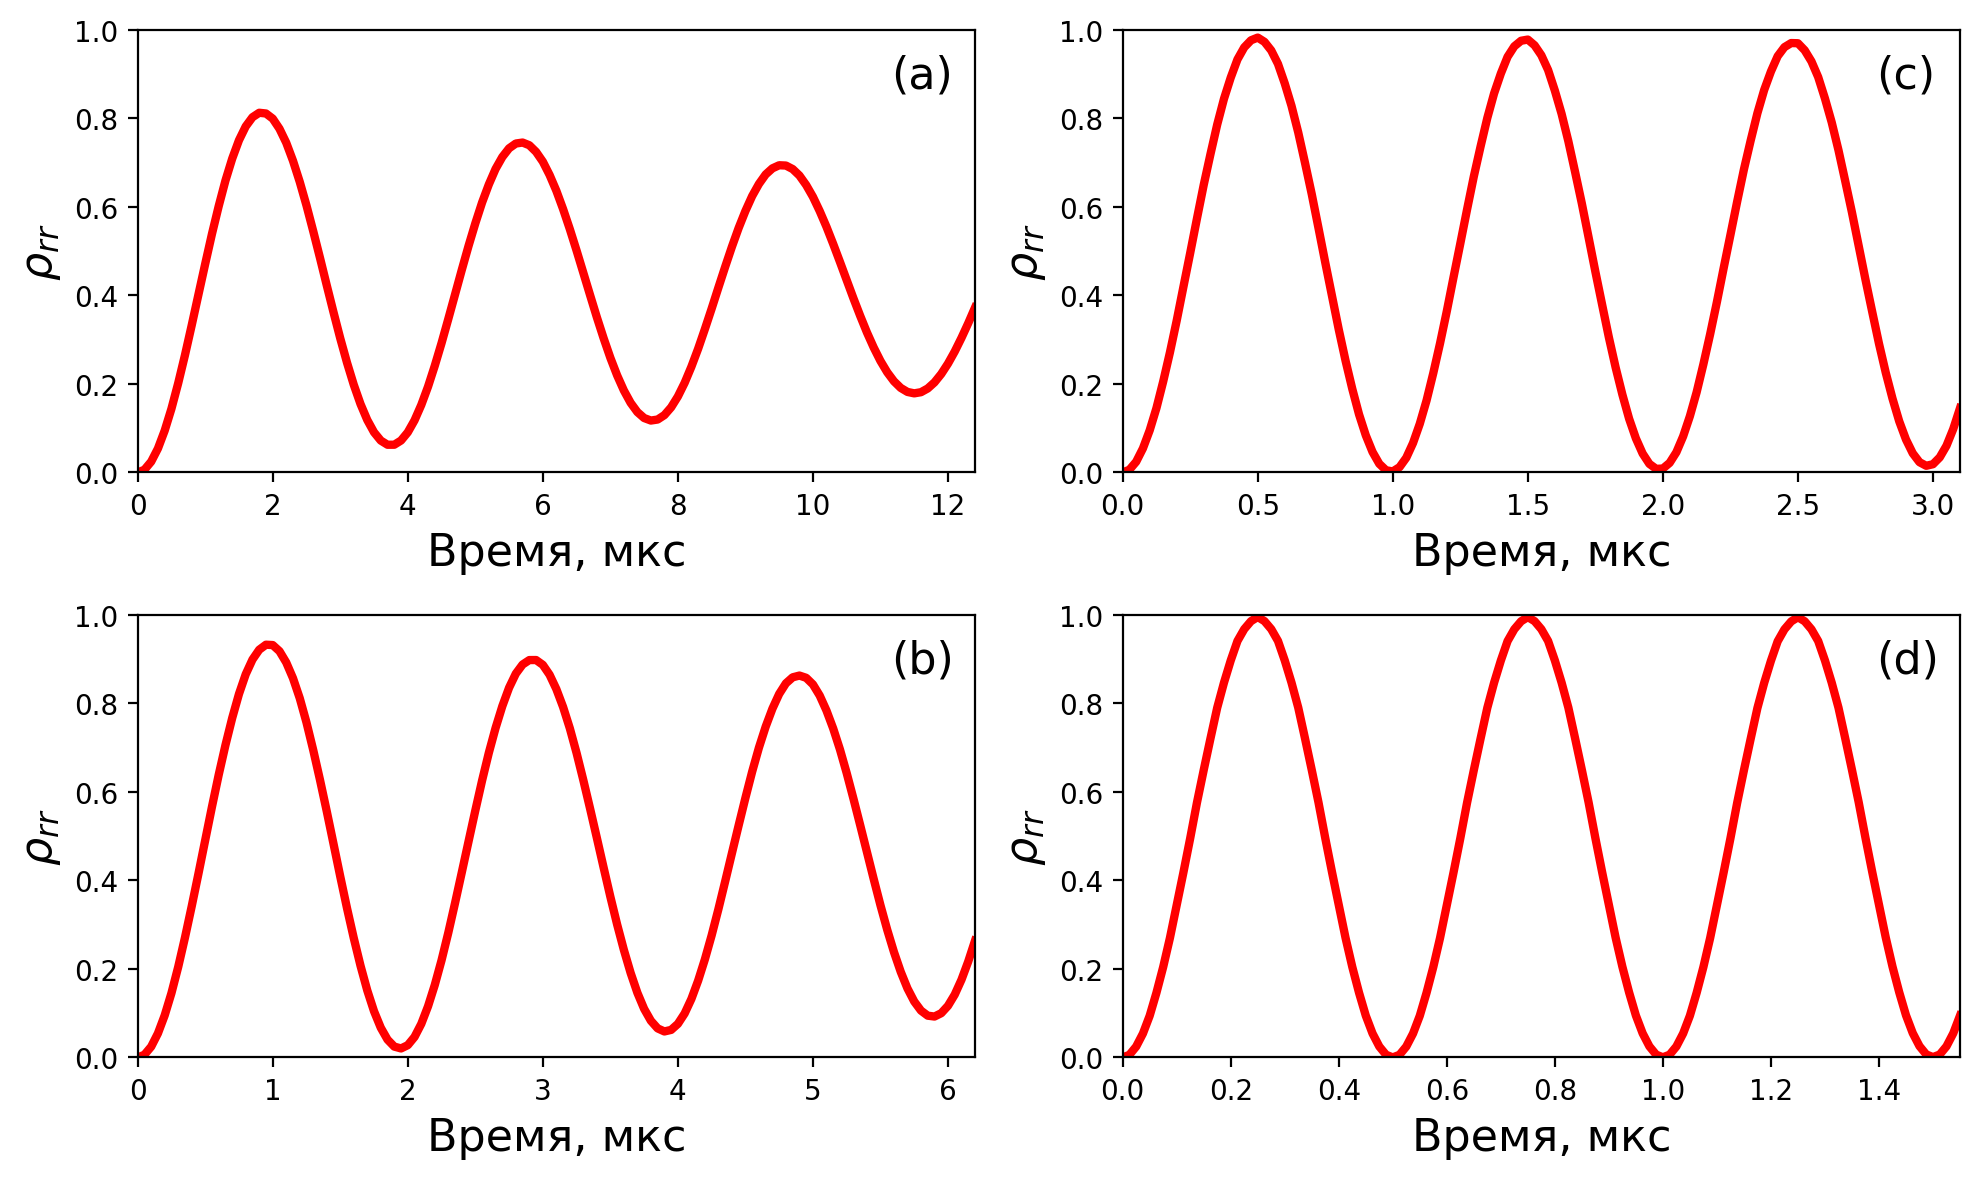

In [22]:
linewidth = 3.0;
fontsize = 16.0;

nr = r ⊗ dagger(r);

figure(figsize=(10,6), dpi=200)

subplot(221)
plot(tspan_250, expect(nr, ρ_mean_250), color="red", linewidth=linewidth)
# xlabel("Time, μs", fontsize=fontsize)
xlabel("Время, мкс", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_250))
ylim(0.0, 1.0)
text(maximum(tspan_250)*9/10, 0.87, "(a)", fontsize=fontsize)


subplot(222)
plot(tspan_1000, expect(nr, ρ_mean_1000), color="red", linewidth=linewidth)
# xlabel("Time, μs", fontsize=fontsize)
xlabel("Время, мкс", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_1000))
ylim(0.0, 1.0)
text(maximum(tspan_1000)*9/10, 0.87, "(c)", fontsize=fontsize)


subplot(223)
plot(tspan_500, expect(nr, ρ_mean_500), color="red", linewidth=linewidth)
# xlabel("Time, μs", fontsize=fontsize)
xlabel("Время, мкс", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_500))
ylim(0.0, 1.0)
text(maximum(tspan_500)*9/10, 0.87, "(b)", fontsize=fontsize)


subplot(224)
plot(tspan_2000, expect(nr, ρ_mean_2000), color="red", linewidth=linewidth)
xlabel("Время, мкс", fontsize=fontsize)
# xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_2000))
ylim(0.0, 1.0)
text(maximum(tspan_2000)*9/10, 0.87, "(d)", fontsize=fontsize)

tight_layout()

savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/dopler.png", dpi=300)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/dopler.pdf", dpi=300)
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/dopler.svg", dpi=300)
gcf()

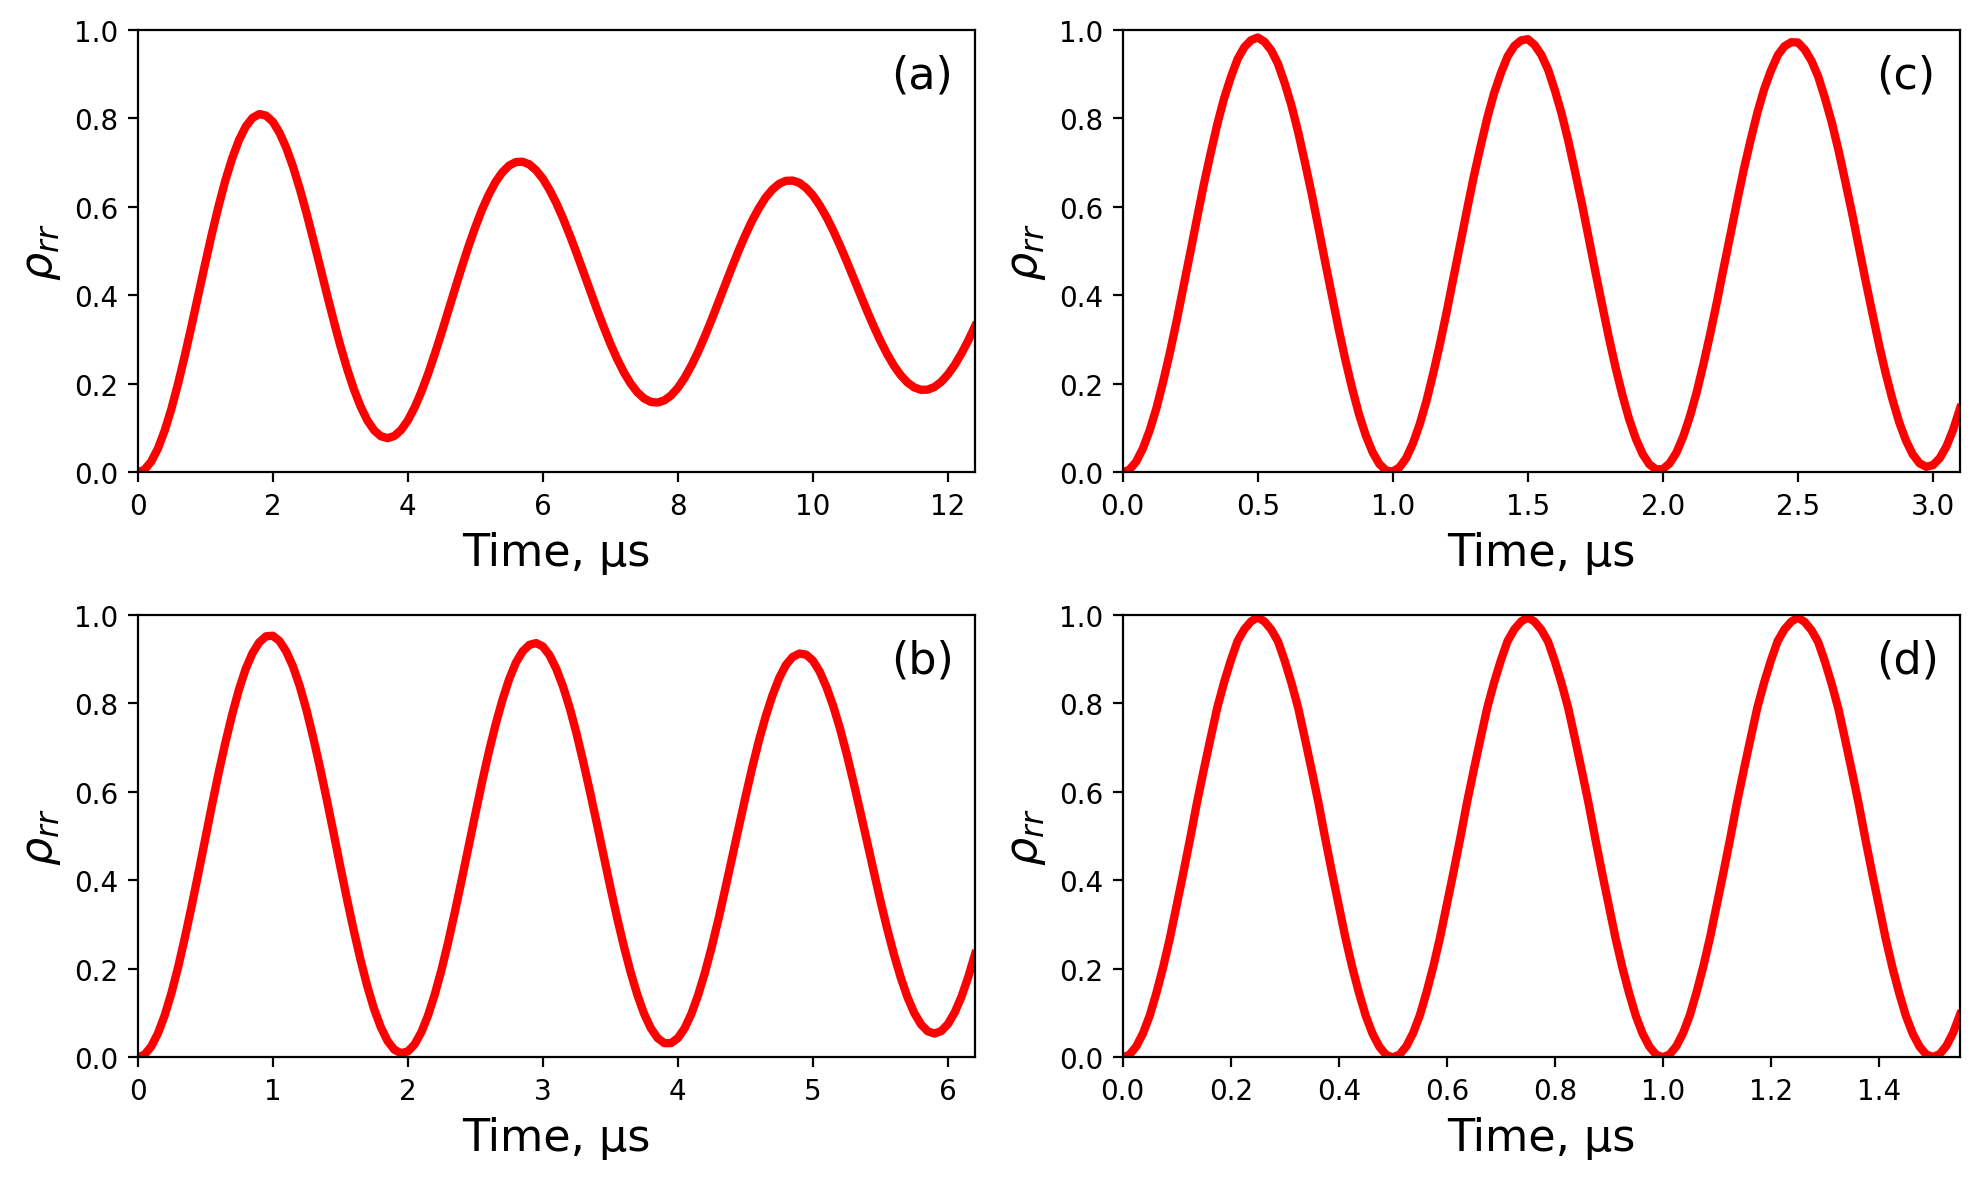

In [12]:
linewidth = 3.0;
fontsize = 16.0;

nr = r ⊗ dagger(r);

figure(figsize=(10,6), dpi=200)

subplot(221)
plot(tspan_250, expect(nr, ρ_mean_250), color="red", linewidth=linewidth)
# xlabel("Time, μs", fontsize=fontsize)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_250))
ylim(0.0, 1.0)
text(maximum(tspan_250)*9/10, 0.87, "(a)", fontsize=fontsize)


subplot(222)
plot(tspan_1000, expect(nr, ρ_mean_1000), color="red", linewidth=linewidth)
# xlabel("Time, μs", fontsize=fontsize)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_1000))
ylim(0.0, 1.0)
text(maximum(tspan_1000)*9/10, 0.87, "(c)", fontsize=fontsize)


subplot(223)
plot(tspan_500, expect(nr, ρ_mean_500), color="red", linewidth=linewidth)
# xlabel("Time, μs", fontsize=fontsize)
xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_500))
ylim(0.0, 1.0)
text(maximum(tspan_500)*9/10, 0.87, "(b)", fontsize=fontsize)


subplot(224)
plot(tspan_2000, expect(nr, ρ_mean_2000), color="red", linewidth=linewidth)
xlabel("Time, μs", fontsize=fontsize)
# xlabel("Time, μs", fontsize=fontsize)
ylabel("\$ \\rho_{rr} \$", fontsize=fontsize)
xlim(0.0, maximum(tspan_2000))
ylim(0.0, 1.0)
text(maximum(tspan_2000)*9/10, 0.87, "(d)", fontsize=fontsize)

tight_layout()

savefig("/Users/goloshch/Desktop/Materials/Workshops:Conferences/2023/ФУХА/presentation/images/dopler_eng.png", dpi=300)
gcf()

### Finite contrast, Browayes.

- if I measure recapture probability $p_{recap}$ from switch-off time $\tau$, I can retrieve dsitribution of atoms over velocities. It seems like $\frac{d}{d\tau}p_{recap}(\tau)$ should give some insight about it.


- $\varepsilon ' \simeq \Gamma_R t_{recap}$, where $t_{recap}=\int_{0}^{\infty} p_{recap}(t)dt$, $\Gamma_R $ - Rydberg lifetime



- recapture probability is modeled using Monte-Carlo modelling with free-flight regime, anti-trapping